Iteration 0:   0%|          | 0/10 [00:00<?, ?it/s]/root/rl_utils.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(advantage_list, dtype=torch.float)
Iteration 210: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it, episode=2110, return=-116.474]


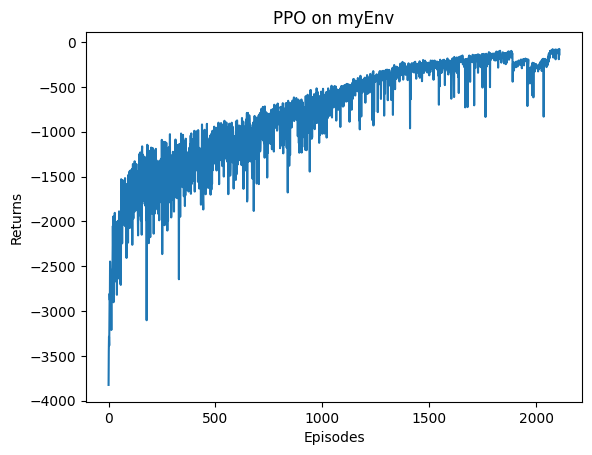

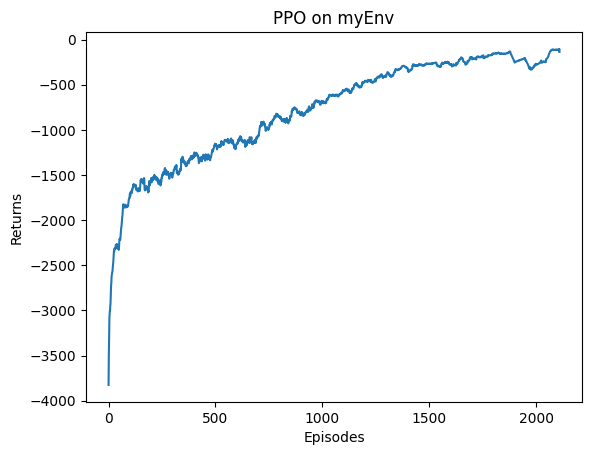

state: [[-0.5, 0.0, -0.31, 0.012], [2.5, 0.0, 0.03, 0.012], [1.0, -0.5, -0.07, -0.31], [-2.0, 3.75, -0.15, 0.065], [-6.5, -0.3333333333333333, 0.045, -0.06666666666666667], [5.0, 1.75, 0.1, -0.020000000000000004], [3.5, -1.1666666666666667, 0.19, -0.05333333333333334], [-2.5, 3.75, 0.06, 0.065], [9.0, 1.5, -0.12, -0.024999999999999994], [-3.0, 0.2, 0.08, 0.023000000000000003]] action [[-1.5458388328552246], [2.2030081748962402], [-0.055847324430942535], [3.1347477436065674], [3.2538270950317383], [1.5717763900756836], [7.026501178741455], [0.20868408679962158], [-1.1874576807022095], [0.9703854918479919]]
state: [[-1.0, 0.012, -0.5, 0.012], [2.970601634979248, 0.012, 0.4706016349792481, 0.012], [0.9188305351138115, -1.0, -0.08116946488618851, -0.5], [-1.5230504512786864, 4.192478456497192, 0.47694954872131345, 0.4424784564971924], [-6.0, -0.2517737555503845, 0.5, 0.08155957778294885], [5.414355278015137, 1.94471608504653, 0.4143552780151367, 0.19471608504652982], [4.0, -1.0008276996016

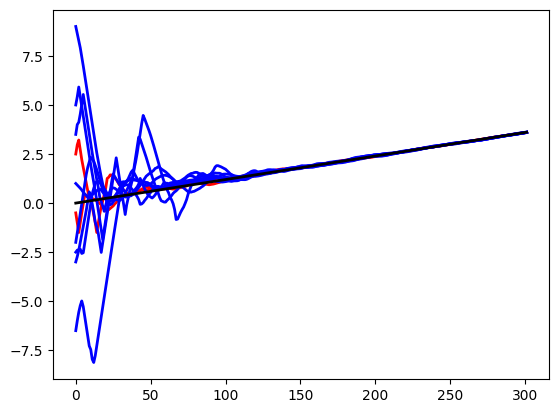

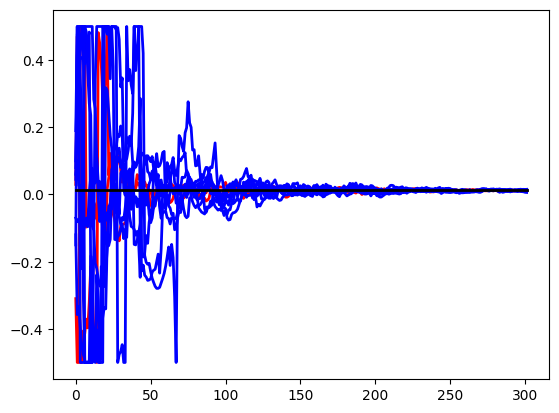

In [1]:
from myEnv_dual_a11 import MultiAgentEnv
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils
import pickle
from tqdm import tqdm


class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = 0.1*torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x)) + 0.001
        return mu, std

    # def forward(self, x):
    #    x = F.tanh(x)
    #    x = self.fc1(x)
    #    mu = 2*self.fc_mu(x)
    #    std = F.softplus(self.fc_std(x))
    #    return mu, std


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        hidden_dim = 2 * hidden_dim
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return self.fc4(x)


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''

    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device, direct):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        if direct > 0:
            self.critic = ValueNet(state_dim, hidden_dim).to(device)
        else:
            self.critic = ValueNet(state_dim * n_agents, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        #action = mu
        action = action.tolist()[0]
        return action


class MAPPO_agent:
    def __init__(self, state_dims, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.agents = []
        self.agents.append(PPOContinuous(state_dims, hidden_dim, action_dim, actor_lr,
                                         critic_lr, lmbda, epochs, eps, gamma, device, 1))
        self.agents.append(PPOContinuous(state_dims, hidden_dim, action_dim, actor_lr,
                                         critic_lr, lmbda, epochs, eps, gamma, device, 0))
        self.gamma = gamma
        self.critic_criterion = torch.nn.MSELoss()
        self.device = device

    def take_action(self, states):
        actions = []
        for i in range(n_agents):
            if i < env.dirct:
                action = self.agents[0].take_action(states[i])
            else:
                action = self.agents[1].take_action(states[i])
            actions.append(action)
        return actions

    def update(self, transition_dict, i_agent):

        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).to(self.device)
        actions = actions[:, i_agent]

        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).to(self.device)
        rewards = rewards[:, i_agent].unsqueeze(-1)

        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)

        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        states_flatten = states.view(states.size(0), -1)
        states = states[:, i_agent, :]

        if i_agent < env.dirct:
            cur_agt = self.agents[0]
            next_states = next_states[:, i_agent, :]
        else:
            cur_agt = self.agents[1]
            next_states = next_states.view(next_states.size(0), -1)

        td_target = rewards + self.gamma * cur_agt.critic(next_states) * (1 - dones)
        if i_agent < env.dirct:
            td_delta = td_target - cur_agt.critic(states)
        else:
            td_delta = td_target - cur_agt.critic(states_flatten)

        advantage = rl_utils.compute_advantage(self.gamma, cur_agt.lmbda,
                                               td_delta.cpu()).to(self.device)
        mu, std = cur_agt.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(cur_agt.epochs):
            mu, std = cur_agt.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - cur_agt.eps, 1 + cur_agt.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            if i_agent < env.dirct:
                critic_loss = torch.mean(
                    F.mse_loss(cur_agt.critic(states), td_target.detach()))
            else:
                critic_loss = torch.mean(
                    F.mse_loss(cur_agt.critic(states_flatten), td_target.detach()))
            cur_agt.actor_optimizer.zero_grad()
            cur_agt.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            cur_agt.actor_optimizer.step()
            cur_agt.critic_optimizer.step()


actor_lr = 1e-5
critic_lr = 1e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.95
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'myEnv'
env = MultiAgentEnv()
n_agents = env.n_agents - 1
torch.manual_seed(0)
state_dim = 4
action_dim = 1  # 连续动作空间

agent = MAPPO_agent(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    lmbda, epochs, eps, gamma, device)


# 加载模型
#agent.agents[0].critic.load_state_dict(torch.load('MAPPO_dual/a_3_v_0.5_t_300_act_0.02/critic0.pth'))
#agent.agents[0].actor.load_state_dict(torch.load('MAPPO_dual/a_3_v_0.5_t_300_act_0.02/actor0.pth'))
#agent.agents[1].actor.load_state_dict(torch.load('MAPPO_dual/a_3_v_0.5_t_300_act_0.02/actor1.pth'))

return_list = []
best_return = -300
for i in range(211):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, error, _ = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += error
            if episode_return > best_return:
                torch.save(agent.agents[0].critic.state_dict(), 'MAPPO_dual/critic0.pth')
                torch.save(agent.agents[0].actor.state_dict(), 'MAPPO_dual/actor0.pth')
                torch.save(agent.agents[1].critic.state_dict(), 'MAPPO_dual/critic1.pth')
                torch.save(agent.agents[1].actor.state_dict(), 'MAPPO_dual/actor1.pth')
                best_return = episode_return
            return_list.append(episode_return)
            for a_i in range(n_agents):
                agent.update(transition_dict, a_i)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                  'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

# 保存return_list
with open('MAPPO_dual_return_list.pkl', 'wb') as f:
    pickle.dump(return_list, f)

# 加载return_list
#with open('return_list.pkl', 'rb') as f:
#    return_list = pickle.load(f)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

state = env.reset()
# 加载模型
agent.agents[0].actor.load_state_dict(torch.load('MAPPO_dual/actor0.pth'))
agent.agents[1].actor.load_state_dict(torch.load('MAPPO_dual/actor1.pth'))

# 循环，直到环境结束
done = False
while not done:
    action = agent.take_action(state)  # 选择动作
    print("state:", state, "action", action)
    state, reward, done, error, _ = env.step(action)  # 执行动作

env.render()  # 显示环境

env.close()